In [1]:
import os
import sys
import glob
import scipy
import pickle
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
from collections import defaultdict
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

%matplotlib inline
sns.set_style('whitegrid')
pd.set_option('display.max_rows', 100)
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['pdf.fonttype'] = 42
pd.set_option('display.max_columns', 100)

sys.path.append('/home/mattolm/Bio_scripts/')

from IPython.display import display, HTML

# Load

In [2]:
data_folder = '/data1/bio_db/refseq/parsed/data_tables/'
save_folder = '/data1/bio_db/refseq/parsed/data_tables/figures/v6/'

# Get scores

In [3]:
Tdb = pd.read_pickle('/data1/bio_db/refseq/analysis/singleCopyGenes_2/data_tables/Thresholds_v3.pickle')

Mdb = Tdb.copy()
Mdb['score'] = [p + r for p, r in zip(Mdb['precision'], Mdb['recall'])]
Mdb = Mdb.sort_values('score', ascending=False)
Mdb = Mdb[~Mdb['genomeList'].isin(['refseqTheta'])]

# Get the highest average score
table = defaultdict(list)
g2s = {}
for gene, db in Mdb.groupby('gene'):
    for thresh, d in db.groupby('threshold'):
        table['thresh'].append(thresh)
        table['gene'].append(gene)
        table['avg_score'].append(np.mean(d['score'].drop_duplicates()))
adb = pd.DataFrame(table)
adb = adb.sort_values('avg_score', ascending=False)
adb = adb.drop_duplicates(subset=['gene'])
g2s = adb.set_index('gene')['thresh'].to_dict()

In [4]:
# Filter
Mdb = Mdb[[True if float(g2s[g]) == float(s) else False for g, s in zip(Mdb['gene'], Mdb['threshold'])]]

# Get recoverability

In [5]:
Rdb = pd.read_csv('/data1/bio_db/refseq/analysis/singleCopyGenes_2/data_tables/EssentialHMMs_copyNumber_v2.csv')
#Rdb = Rdb[~Rdb['description'].isna()]
Rdb[Rdb['description'] == '0']

d = Rdb[Rdb['genomeList'] == 'refseqTheta']
d = d[d['percentage_recovered'] >= 80]
g2d = d.set_index('gene')['description'].to_dict()
FILT_GENES = list(d['gene'].unique())

## Merge

In [6]:
MRdb = pd.merge(Mdb, Rdb[['genomeList', 'gene', 'recoverability', 'percentage_recovered', 'description']], on=['genomeList', 'gene'],
               how='right')
MRdb['description'] = MRdb['gene'].map(g2d)
MRdb.head()


,genomeList,gene,threshold,method,metric,precision,recall,fpr,tpr,score,recoverability,percentage_recovered,description
0,oceanList,TIGR00471,0.962,ani,same_cluster,1.000000,1.000000,0.000000,1.000000,2.000000,0.999142,7.032590,NaN
1,infantList,TIGR00408,0.969,ani,same_cluster,1.000000,0.995778,0.000000,0.995778,1.995778,0.101663,8.953168,NaN
2,soilList,TIGR03263,0.963,ani,same_cluster,0.984523,0.976962,0.000102,0.976962,1.961485,4.199570,78.106509,guanyl_kin: guanylate kinase
3,oceanList,TIGR00496,0.966,ani,same_cluster,0.982379,0.978070,0.000008,0.978070,1.960449,8.993997,83.962264,frr: ribosome recycling factor
4,infantList,TIGR02729,0.954,ani,same_cluster,0.974833,0.984529,0.000499,0.984529,1.959362,1.228609,96.740129,Obg_CgtA: Obg family GTPase CgtA


## Colors

In [11]:
# Load names of the rp16
RPs = [x[2:] for x in pd.read_csv('/data1/bio_db/refseq/parsed/data_tables/Theta_locations_v2.csv')\
       ['protein'].unique() if 'concat' not in x]

g2c = {}
c2l = {}
colors = sns.color_palette()[2:]

# Add the weird bois
for gene in set([x for x in Tdb['gene'].tolist() if (':' in x) & ('a:' not in x)]):
    if gene[:1] == 'g':
        c = colors[0]
        g2c[gene] = c
        c2l[c] = 'Whole genome ANI'
        
#     elif gene[:1] == 'a':
#         c = colors[1]
#         g2c[gene] = c
#         c2l[c] = 'Amino acid ID'
        
    elif gene[:1] == 's':
        c = colors[2]
        g2c[gene] = c
        c2l[c] = 'Concat16'
        
    else:
        assert False, gene

# Add the single copy genes
d = Rdb[(Rdb['gene'].isin(FILT_GENES)) & (Rdb['genomeList'] == 'refseqTheta')]
for gene, description in zip(d['gene'], d['description'].astype(str)):
    
    # RP16
    rp16 = False
    c = colors[4]
    for r in RPs:
        if description[(len(r))*-1:] == r:
            g2c[gene] = c
            rp16 = True
            continue
    if description == 'Ribosomal protein L4/L1 family':
        g2c[gene] = c
        c2l[c] = '16 Ribosomal Proteins'
            
    elif rp16 == True:
        pass
    
    # Other ribosomal proteins
    elif 'ribosomal protein' in description:
        c = 'pink'
        #g2c[gene] = colors[4]
        g2c[gene] = c
        c2l[c] = 'Other ribosomal proteins'
        
    elif 'tRNA ligase' in description:
        c = colors[6]
        g2c[gene] = c
        c2l[c] = 'tRNA ligase'

#     if False:
#         pass
        
    # 16S
    elif description == "16S rRNA gene (full length)":
        c = colors[7]
        g2c[gene] = c
        c2l[c] = '16S rRNA'
        
    # Other    
    else:
        c = 'lightgrey'
        g2c[gene] = c
        c2l[c] = 'Other genes'

In [12]:
MRdb['color'] = MRdb['gene'].map(g2c)
d2c = MRdb.set_index('description')['color'].to_dict()

## Plot

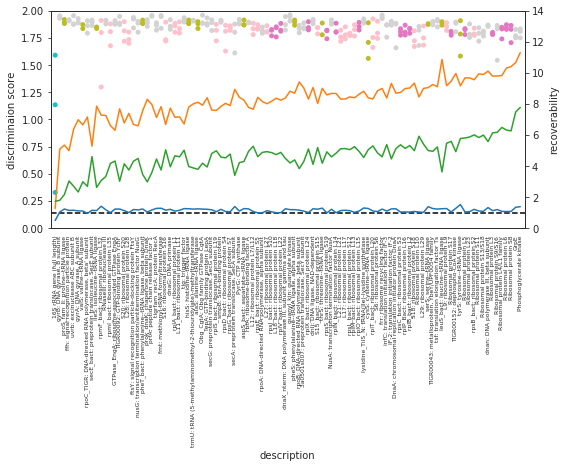

In [13]:
sns.set_style('white')

db = MRdb.copy()

db['gene'] = db['gene'].astype(str)
db = db[db['gene'].isin(FILT_GENES)]

# Add average recoverability
g2l = {g:d['recoverability'].mean() for g, d in db.groupby('gene')}
db['oR'] = db['gene'].map(g2l)

# Sort by recoverability
db = db.sort_values('oR', ascending=True)
nameOrder = list(db['description'].unique())
db['description'] = db['description'].astype('category')
db['description'].cat.reorder_categories(nameOrder, inplace=True)


# Bar plot
#sns.barplot(data=db, x='description', y='score', palette=d2c)
sns.stripplot(data=db, x='description', y='score', palette=d2c, jitter=False)
plt.ylabel('discriminaion score')
plt.xticks(rotation='90')
plt.gca().set_ylim(0, 2)

# x tick size
plt.gca().tick_params(axis = 'x', which = 'major', labelsize = 6)
plt.gca().tick_params(axis = 'x', which = 'minor', labelsize = 6)

# Line plot
ax = plt.gca()
ax2 = ax.twinx()
ax2.axhline(1, ls='--', color='black')
db['recoverability'] = db['recoverability'].astype(float)
for l, d in db.groupby('genomeList'):
    if l in ['refseqTheta']:
        continue
    sns.lineplot(data=d, y='recoverability', x='description', ax=ax2)
ax2.set_ylim(0, 14)

# x tick size
plt.gca().tick_params(axis = 'x', which = 'major', labelsize = 6)
plt.gca().tick_params(axis = 'x', which = 'minor', labelsize = 6)

# Threshold
# ax = plt.gca()
# ax3 = ax.twinx()
# sns.lineplot(data=db, y='threshold', x='description', color='black', ax=ax3)
# #ax2.set_ylim(0, 14)

plt.gca().tick_params(axis = 'x', which = 'major', labelsize = 6)
plt.gca().tick_params(axis = 'x', which = 'minor', labelsize = 6)

plt.xlim(-1, len(db['description'].unique()))

plt.gcf().set_size_inches(8.5, 4)
plt.gcf().savefig(save_folder + 'MAG_delineation_v3.2.pdf', bbox_inches='tight')

plt.show()

## Adjust environment color palette

In [45]:
colors = sns.color_palette()
e2c = {}
e2c['soilList'] = colors[2]
e2c['oceanList'] = colors[0]
e2c['infantList'] = colors[5]

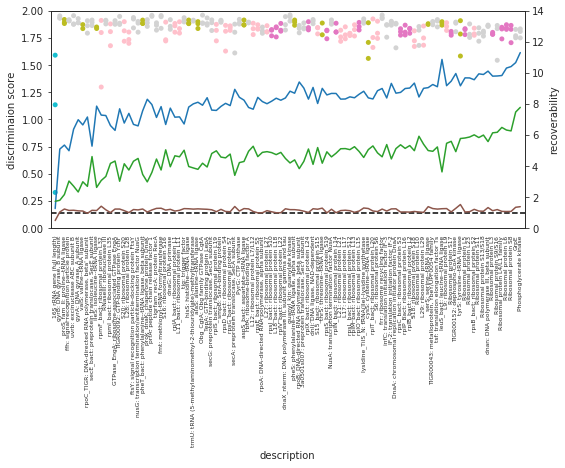

In [46]:
sns.set_style('white')

db = MRdb.copy()

db['gene'] = db['gene'].astype(str)
db = db[db['gene'].isin(FILT_GENES)]

# Add average recoverability
g2l = {g:d['recoverability'].mean() for g, d in db.groupby('gene')}
db['oR'] = db['gene'].map(g2l)

# Sort by recoverability
db = db.sort_values('oR', ascending=True)
nameOrder = list(db['description'].unique())
db['description'] = db['description'].astype('category')
db['description'].cat.reorder_categories(nameOrder, inplace=True)


# Bar plot
#sns.barplot(data=db, x='description', y='score', palette=d2c)
sns.stripplot(data=db, x='description', y='score', palette=d2c, jitter=False)
plt.ylabel('discriminaion score')
plt.xticks(rotation='90')
plt.gca().set_ylim(0, 2)

# x tick size
plt.gca().tick_params(axis = 'x', which = 'major', labelsize = 6)
plt.gca().tick_params(axis = 'x', which = 'minor', labelsize = 6)

# Line plot
ax = plt.gca()
ax2 = ax.twinx()
ax2.axhline(1, ls='--', color='black')
db['recoverability'] = db['recoverability'].astype(float)
for l, d in db.groupby('genomeList'):
    if l in ['refseqTheta']:
        continue
    sns.lineplot(data=d, y='recoverability', x='description', ax=ax2, color=e2c[l])
ax2.set_ylim(0, 14)

# x tick size
plt.gca().tick_params(axis = 'x', which = 'major', labelsize = 6)
plt.gca().tick_params(axis = 'x', which = 'minor', labelsize = 6)

# Threshold
# ax = plt.gca()
# ax3 = ax.twinx()
# sns.lineplot(data=db, y='threshold', x='description', color='black', ax=ax3)
# #ax2.set_ylim(0, 14)

plt.gca().tick_params(axis = 'x', which = 'major', labelsize = 6)
plt.gca().tick_params(axis = 'x', which = 'minor', labelsize = 6)

plt.xlim(-1, len(db['description'].unique()))

plt.gcf().set_size_inches(8.5, 4)
plt.gcf().savefig(save_folder + 'MAG_delineation_v3.3.pdf', bbox_inches='tight')

plt.show()

## Make correlation plots

In [22]:
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.graphics.regressionplots import abline_plot

def compare_metrics_linear(db, met1, met2, minval=0):
    # Prepare
    Fdb = db.copy()
    #Fdb = Fdb[(Fdb[met1] > minval) & (Fdb[met2] > minval)]
    #Fdb = Fdb[Fdb['genome1'] != Fdb['genome2']]
    Fdb = Fdb.dropna()
    
    x = Fdb[met1]
    y = Fdb[met2]

    # Fit to model
    model = LinearRegression(fit_intercept=True)
    X = sm.add_constant(x)
    model = sm.OLS(y, X).fit()
    predictions = model.predict(X)

    # Scatter plot
    plt.scatter(x, y, s=10, c='black')
    plt.xlabel(met1)
    plt.ylabel(met2)
    #plt.xlim(minval, 1)
    #plt.ylim(minval, 1)
    
    # Line plot
    ax = plt.gca()
    abline_plot(model_results=model, ax=ax)
    
    # Print out the statistics
    R2 = model.rsquared
    #plt.gcf().suptitle("{0} vs {1}".format(met1, met2))
    ax.set_title("{0} = ({1:.2f} * {2}) + {3:.2f} ;R2={4:.2f}".format(\
        met2, model.params[met1], met1, model.params['const'], R2))
    
    # Show
    plt.gcf().set_size_inches(4,4)
    plt.show()

## Add length

In [57]:
Rdb

,gene,count,genomeList,description,percentage_recovered,avg_copy_number,recoverability,median_length
0,TIGR00234,11439.0,infantList,tyrS: tyrosine--tRNA ligase,98.071625,1.175094,1.522156,444.5
1,TIGR01031,10618.0,infantList,rpmF_bact: ribosomal protein L32,94.719927,1.157538,1.412908,75.0
2,TIGR00963,10492.0,infantList,"secA: preprotein translocase, SecA subunit",96.740129,1.175605,1.396141,1127.0
3,TIGR00414,10413.0,infantList,serS: serine--tRNA ligase,97.337006,1.097170,1.385629,570.0
4,PGK,10404.0,infantList,Phosphoglycerate kinase,99.035813,1.050533,1.384431,405.0
5,GrpE,10107.0,infantList,GrpE,98.025712,1.063700,1.344910,280.0
6,TIGR00663,9969.0,infantList,"dnan: DNA polymerase III, beta subunit",97.979798,1.022024,1.326547,448.0
7,TIGR02432,9768.0,infantList,lysidine_TilS_N: tRNA(Ile)-lysidine synthetase,97.842057,1.000939,1.299800,510.0
8,TIGR00418,9701.0,infantList,thrS: threonine--tRNA ligase,96.189164,1.080668,1.290885,791.5
9,TIGR00460,9653.0,infantList,fmt: methionyl-tRNA formyltransferase,96.189164,1.029594,1.284498,448.5


In [64]:
Rdb = pd.read_csv('/data1/bio_db/refseq/analysis/singleCopyGenes_2/data_tables/EssentialHMMs_copyNumber_v2.2.csv')

MRLdb = pd.merge(MRdb, Rdb[['gene', 'genomeList', 'median_length']], on=['gene', 'genomeList'], how='left')
rl = MRLdb[MRLdb['genomeList'] == 'refseqTheta'].set_index('gene')['median_length'].to_dict()
MRLdb['discrepency'] = [ml - rl[g] for ml, g in zip(MRLdb['median_length'], MRLdb['gene'])]

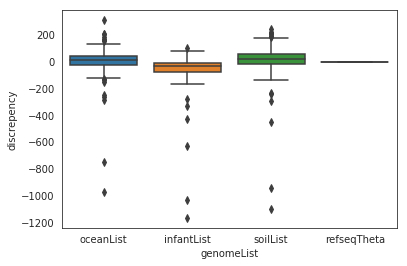

In [66]:
sns.boxplot(data=MRLdb, x='genomeList', y='discrepency')
plt.show()

## View length

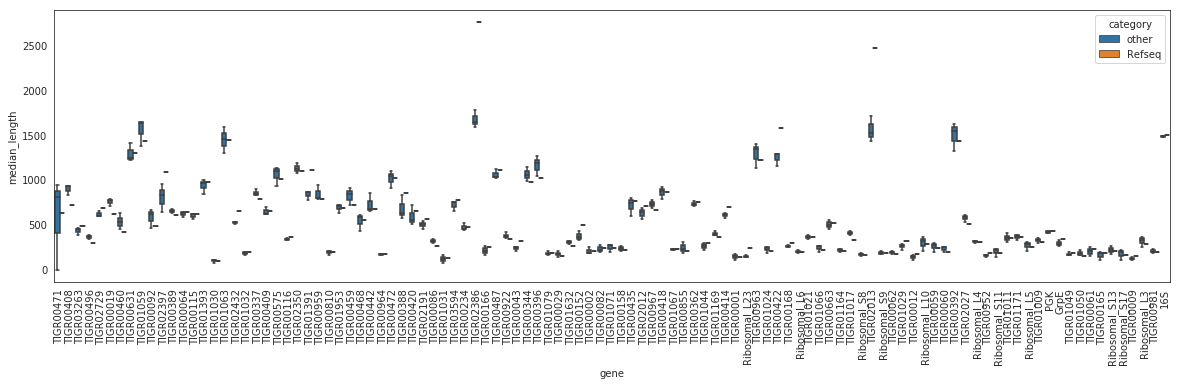

In [61]:
Fdb = MRLdb.copy()
Fdb['category'] = ['Refseq' if h == 'refseqTheta' else 'other' for h in Fdb['genomeList']]

sns.boxplot(data=Fdb, x='gene', y= 'median_length', hue='category')
plt.xticks(rotation=90)
plt.gcf().set_size_inches(20, 5)
plt.show()

In [55]:
Fdb

,genomeList,gene,threshold,method,metric,precision,recall,fpr,tpr,score,recoverability,percentage_recovered,description,color,length,category
0,oceanList,TIGR00471,0.962,ani,same_cluster,1.000000,1.000000,0.000000,1.000000,2.000000,0.999142,7.032590,NaN,NaN,629.5,other
1,infantList,TIGR00408,0.969,ani,same_cluster,1.000000,0.995778,0.000000,0.995778,1.995778,0.101663,8.953168,NaN,NaN,724.0,other
2,soilList,TIGR03263,0.963,ani,same_cluster,0.984523,0.976962,0.000102,0.976962,1.961485,4.199570,78.106509,guanyl_kin: guanylate kinase,lightgrey,486.0,other
3,oceanList,TIGR00496,0.966,ani,same_cluster,0.982379,0.978070,0.000008,0.978070,1.960449,8.993997,83.962264,frr: ribosome recycling factor,lightgrey,292.0,other
4,infantList,TIGR02729,0.954,ani,same_cluster,0.974833,0.984529,0.000499,0.984529,1.959362,1.228609,96.740129,Obg_CgtA: Obg family GTPase CgtA,lightgrey,681.0,other
5,oceanList,TIGR00408,0.969,ani,same_cluster,0.985915,0.972222,0.000014,0.972222,1.958138,2.931389,32.161235,NaN,NaN,724.0,other
6,infantList,TIGR00019,0.966,ani,same_cluster,0.983191,0.974514,0.000344,0.974514,1.957705,1.172987,95.179063,prfA: peptide chain release factor 1,lightgrey,623.0,other
7,soilList,TIGR00460,0.946,ani,same_cluster,0.993696,0.962279,0.000045,0.962279,1.955975,3.746638,70.952125,fmt: methionyl-tRNA formyltransferase,lightgrey,414.0,other
8,infantList,TIGR00631,0.953,ani,same_cluster,0.984226,0.970374,0.000314,0.970374,1.954600,1.154491,93.617998,uvrb: excinuclease ABC subunit B,lightgrey,1303.0,other
9,soilList,TIGR01059,0.959,ani,same_cluster,0.985664,0.967176,0.000106,0.967176,1.952840,1.795051,61.538462,"gyrB: DNA gyrase, B subunit",lightgrey,1427.5,other


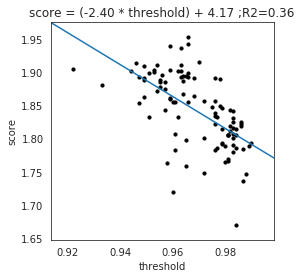

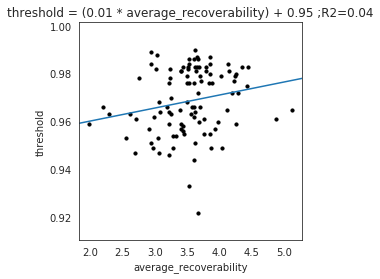

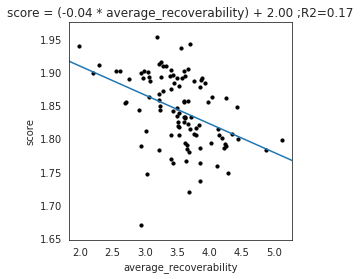

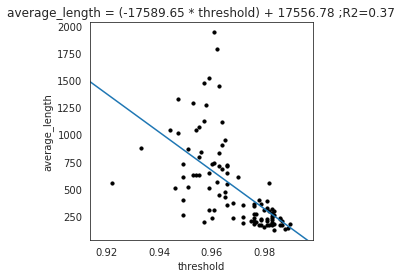

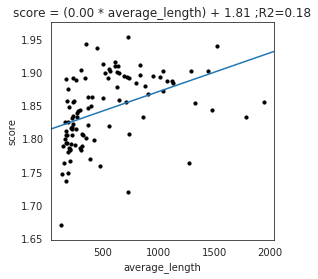

In [77]:
Fdb = MRLdb.copy()

g2l = {g:d['recoverability'].mean() for g, d in Fdb.groupby('gene')}
Fdb['average_recoverability'] = Fdb['gene'].map(g2l)

g2l = {g:d['median_length'].mean() for g, d in Fdb.groupby('gene')}
Fdb['average_length'] = Fdb['gene'].map(g2l)

g2l = {g:d['score'].mean() for g, d in Fdb.groupby('gene')}
Fdb['score'] = Fdb['gene'].map(g2l)

Fdb = Fdb.drop_duplicates(subset=['gene'])
Fdb = Fdb[Fdb['gene'] != '16S']

compare_metrics_linear(Fdb, 'threshold', 'score')
plt.show()

compare_metrics_linear(Fdb, 'average_recoverability', 'threshold')
plt.show()

compare_metrics_linear(Fdb, 'average_recoverability', 'score')
plt.show()

compare_metrics_linear(Fdb, 'threshold', 'average_length')
plt.show()

compare_metrics_linear(Fdb, 'average_length', 'score')
plt.show()

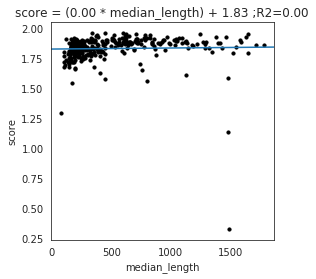

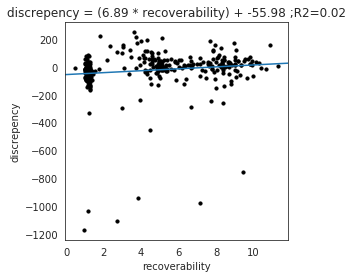

In [72]:
Fdb = MRLdb.copy()

compare_metrics_linear(Fdb, 'median_length', 'score')
plt.show()

compare_metrics_linear(Fdb, 'recoverability', 'discrepency')
plt.show()

## Conclusion: 

If you have a higher threshold you have a lower score (strongest signal) and higher recoverability (unclear why). Likely because of this, if you have a higher recoverability you have a lower score (this could also be because you get mis-binned more often?) 

## Compare thresholds

In [45]:
Tdb = pd.read_pickle('/data1/bio_db/refseq/analysis/singleCopyGenes_2/data_tables/Thresholds_v3.2_refSeq.pickle')

Tdb['score'] = [p + r for p, r in zip(Tdb['precision'], Tdb['recall'])]
Tdb = Tdb.sort_values('score', ascending=False)
Tdb = Tdb.drop_duplicates(subset=['genomeList', 'gene'])
Tdb = Tdb[Tdb['genomeList'] == 'refseqTheta']
g2t = Tdb.set_index('gene')['threshold'].to_dict()

In [49]:
table = defaultdict(list)
for gene, db in Mdb.groupby('gene'):
    if gene not in g2t:
        continue
        
    table['gene'].append(gene)
    table['MAG_threshold'].append(db['threshold'].unique()[0])
    table['Refseq_threshold'].append(g2t[gene])
    
Cdb = pd.DataFrame(table)

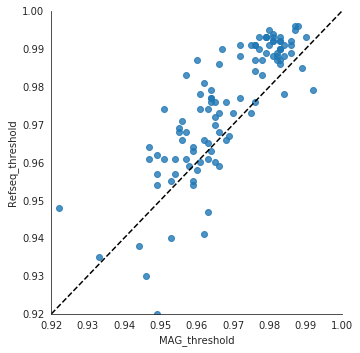

In [65]:
sns.lmplot(data=Cdb, x='MAG_threshold', y='Refseq_threshold', fit_reg=False)
plt.plot([0, 1], [0, 1], ls='--', c='black')
plt.xlim(0.92, 1)
plt.ylim(0.92, 1)
plt.show()

### Look at 16S

In [75]:
Tdb = pd.read_pickle('/data1/bio_db/refseq/analysis/singleCopyGenes_2/data_tables/Thresholds_v3.pickle')
Tdb['score'] = [p + r for p, r in zip(Tdb['precision'], Tdb['recall'])]
Tdb = Tdb.sort_values('score', ascending=False)
Tdb = Tdb.drop_duplicates(subset=['genomeList', 'gene'])
Tdb = Tdb[Tdb['gene'] == '16S']
Tdb

,genomeList,gene,threshold,method,metric,precision,recall,fpr,tpr,score
371,soilList,16S,0.968,ani,same_cluster,0.870246,0.728464,0.002289,0.728464,1.598711
297,refseqTheta,16S,0.995,ani,same_cluster,0.722613,0.836086,0.000802,0.836086,1.558699
199,oceanList,16S,0.998,ani,same_cluster,1.000000,0.342105,0.000000,0.342105,1.342105
3,infantList,16S,0.903,ani,same_cluster,0.139706,0.237910,0.037263,0.237910,0.377616


In [110]:
RBdb = pd.read_pickle('/data1/bio_db/refseq/analysis/singleCopyGenes_2/data_tables/16S_DistanceMatricies_v2.2.pickle')
RBdb = RBdb[RBdb['genomeList'] == 'infantList']
#Rdb = Rdb[Rdb['hmm_name'] == '16S']

In [102]:
def _mini_spark(Cdb=False, ax=False, contrast_col=False, minval=False, bins=False,
                   thresh=False, col=False):
    
    for s, color in zip([True, False], ['green', 'red']):
            sns.distplot([x * 100 for x in Cdb[col][Cdb[contrast_col] == s].dropna() if x*100 >= minval], hist=True, ax=ax,\
                    kde=False, bins=bins, hist_kws={"histtype": "step", 'color':color, "linewidth": 1.5, 'alpha':1, 'zorder':2})
            sns.distplot([x * 100 for x in Cdb[col][Cdb[contrast_col] == s].dropna() if x*100 >= minval], hist=True, ax=ax,\
                    kde=False, bins=bins, hist_kws={"histtype": "stepfilled", 'color':color})

    if thresh != False:
        ax.axvline(thresh*100, c='black', linestyle='-')

def spark_dist(Cdb, cols, c2c=False, minval=0, debug=False, contrast_cols=None,\
              threshs=None, nbins=20, m2n=False):
    '''
    Produce a sparkline of value distributions
    
    Args:
        Cdb = pandas dataframe
        cols = columns of dataframe to use as rows
        
    Optional Args:
        c2c = colors to use (dictionary of columns -> color)
        minval = xlim min value
        contrast_cols = values to use to determine contrast. must be as long as cols
        threshs = values to use to plot with contrast cols. must be as long as cols
    '''
    # set up figure
    num_plots = len(cols)
    fig = plt.figure()
    sns.set_style('white')
    
    if contrast_cols != None:
        assert len(contrast_cols) == len(cols) == len(threshs)

    # make plots
    i = 1
    axs = []
    for c in cols:
        if debug:
            print(i, c, num_plots)
            
        if i == 1: # first plot
            ax1 = fig.add_subplot(num_plots,1,i) # nrows, ncols, plot_number, top sparkline)
            ax = ax1
            if i == num_plots:
                # also last plot
                axL = ax
            i += 1
        elif i == (num_plots): # last plot
            axL = fig.add_subplot(num_plots,1,i, sharex=ax1)
            ax = axL
        else:
            ax = fig.add_subplot(num_plots,1,i, sharex=ax1)
            i += 1
        
        
        _mini_spark(Cdb=Cdb, ax=ax, contrast_col=contrast_cols[i-2], minval=minval, bins=nbins,
                   thresh=threshs[i-2],col=c)
#         if contrast_cols != None:
#             for s, color in zip([True, False], ['green', 'red']):
#                 sns.distplot([x for x in Cdb[c][Cdb[contrast_cols[i-2]] == s].dropna() if x >= minval], hist=True, ax=ax,\
#                         kde=False, bins=20, hist_kws={"histtype": "step", 'color':color, "linewidth": 3})
                
#             ax.axvline(threshs[i-2], c='black', linestyle='-')
        
#         else:
#             sns.distplot([x for x in Cdb[c].dropna() if x >= minval], hist=False, ax=ax)#\,
#                     #kde_kws={'shade':True, 'bw':.001, 'color':c2c[c]})
            
            
        ax.axhline(0, c='grey')#, alpha=0.25)
        if m2n != False:
            ax.set_title(m2n[c], loc='left', pad=-5)
        else:
            ax.set_title(c, loc='left', pad=-5)
        axs.append(ax)


    # remove borders
    for axes in axs:
        plt.setp(axes.get_xticklabels(), visible=False)
        plt.setp(axes.get_yticklabels(), visible=False)
        plt.setp(axes.get_xticklines(), visible=False)
        plt.setp(axes.get_yticklines(), visible=False)
        plt.setp(axes.spines.values(), visible=False)

    # bottom
    plt.setp(axL.get_xticklabels(), visible=True)
    plt.setp(axL.get_xticklines(), visible=True)
    axL.xaxis.tick_bottom()

    # display
    plt.xlim(minval,100)
    
# Fdb = Mdb[Mdb['metric'] == 'same_species']

# DISPLAY = ['16s_ani', 'RPS3_ani', 'concat16_ani']#, 'RPS3_aa_ani', 'concat16_aa_ani']
# #DISPLAY = ['fast_ani', '16s_ani', 'RPS3_ani', 'concat16_ani', 'RPS3_aa_ani', 'concat16_aa_ani']

# m2n = {'fast_ani':'FastANI', '16s_ani':'16S rRNA', 'RPS3_ani':'Ribosomal protein S3 (nucl)', 'concat16_ani':'All ribosomal proteins (nucl)'}

# Fdb = Fdb[Fdb['method'].isin(DISPLAY)]
# Fdb['method'] = pd.Categorical(Fdb['method'], DISPLAY)
# Fdb = Fdb.sort_values('method')

# cols = Fdb['method'].tolist()
# contrast_cols = Fdb['metric'].tolist()
# threshs = Fdb['threshold'].tolist()
# spark_dist(Cdb, cols, m2c, contrast_cols=contrast_cols, threshs=threshs, minval=98, nbins=20, m2n=m2n)
# plt.gcf().set_size_inches(4, 3)

# #plt.savefig(save_folder + 'cutoffs_2.pdf', bbox_inches='tight')
# plt.show()

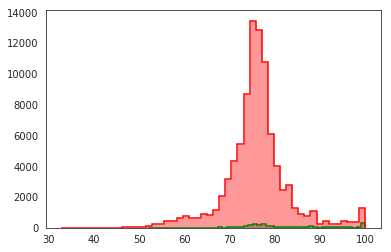

/home/mattolm/.pyenv/versions/3.6.1/lib/python3.6/site-packages/seaborn/distributions.py:198: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
/home/mattolm/.pyenv/versions/3.6.1/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


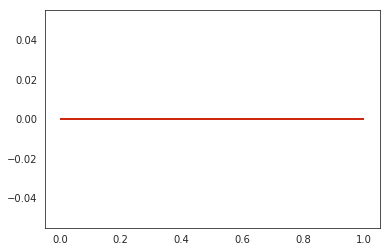

In [108]:
_mini_spark(RBdb[RBdb['hmm_name'] == '16S'], ax=plt.gca(), contrast_col='same_cluster', col='ani', bins=50)
plt.show()

_mini_spark(RBdb[RBdb['hmm_name'] == 'PGK'], ax=plt.gca(), contrast_col='same_cluster', col='ani', bins=50)
plt.show()